In [7]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-05 21:11:30,699 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020', '2021']).filter_within_geometry(sierras)

In [6]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-05 21:07:13,135 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 21:07:13,457 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 21:07:14,766 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 21:07:15,146 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 21:07:15,314 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [24]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-05 21:47:46,068 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 21:47:46,740 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 21:47:49,472 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 21:47:50,484 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 21:47:50,847 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [8]:
fire = sierra_firep.get_fire('CASTLE')

In [9]:
matches = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned, 'agbd')

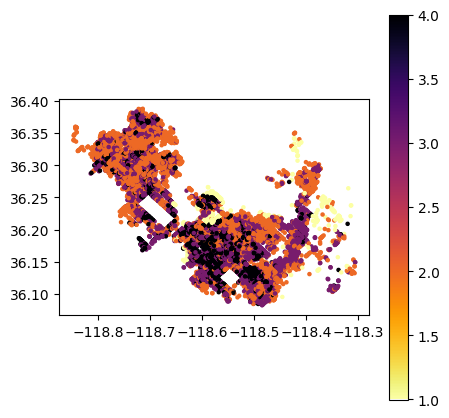

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

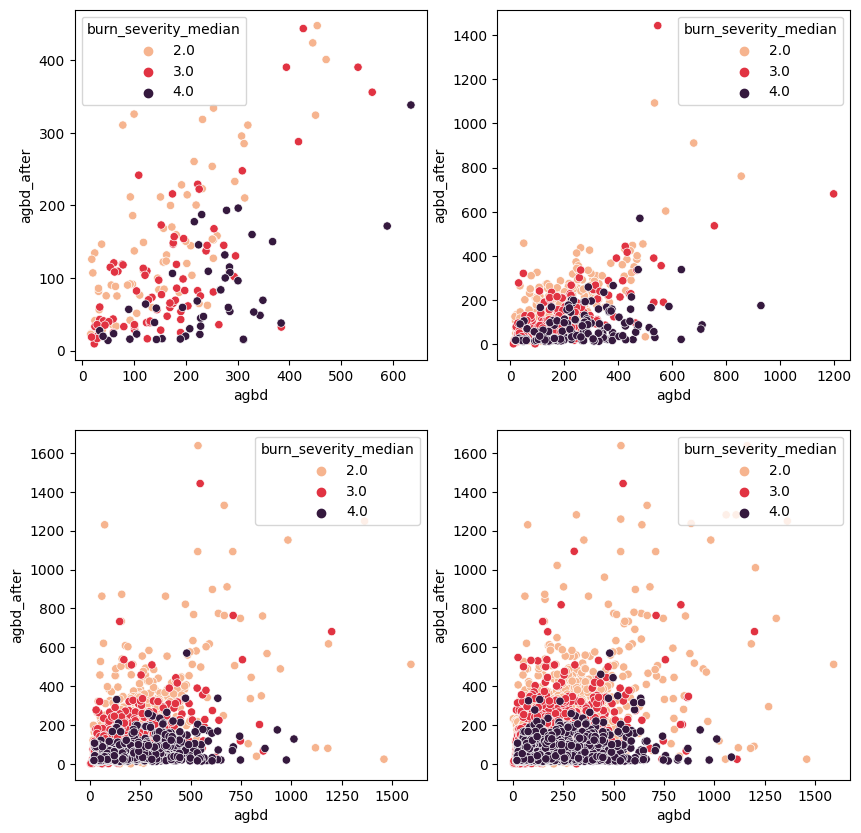

In [11]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

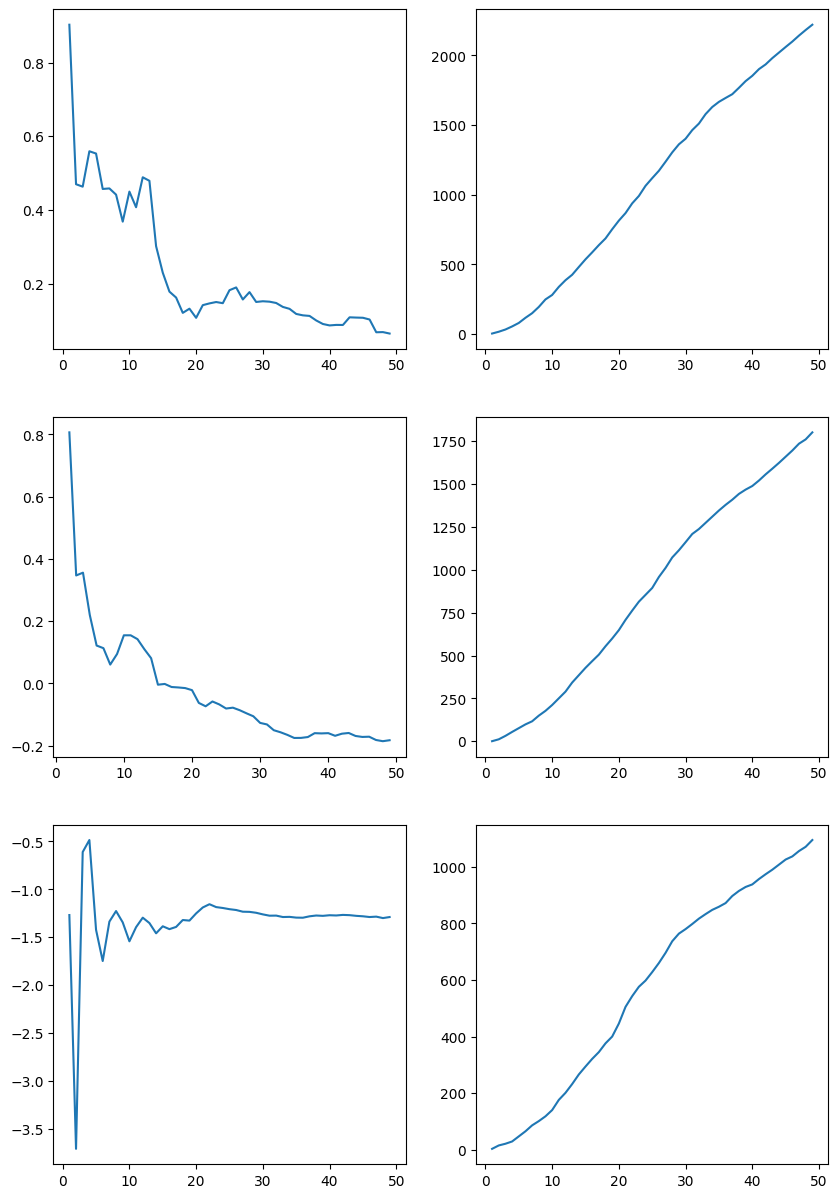

In [12]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [13]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [14]:
close_matches = filter_land_cover(matches[matches.closest_distance < 10])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.76820591].         R squared is : 0.5103136094996531.
The error for coeff = 1 is: 0.37652474413061865.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.60512105].         R squared is : 0.38855689080090794.
The error for coeff = 1 is: 0.056912864009316055.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.17277814].         R squared is : 0.11406055600667753.
The error for coeff = 1 is: -1.5179448896551384.


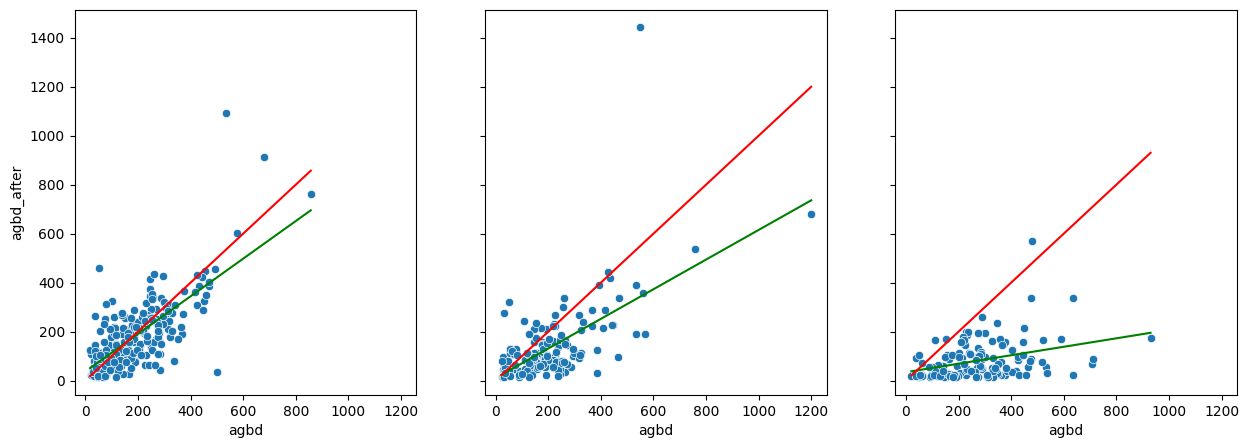

In [15]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

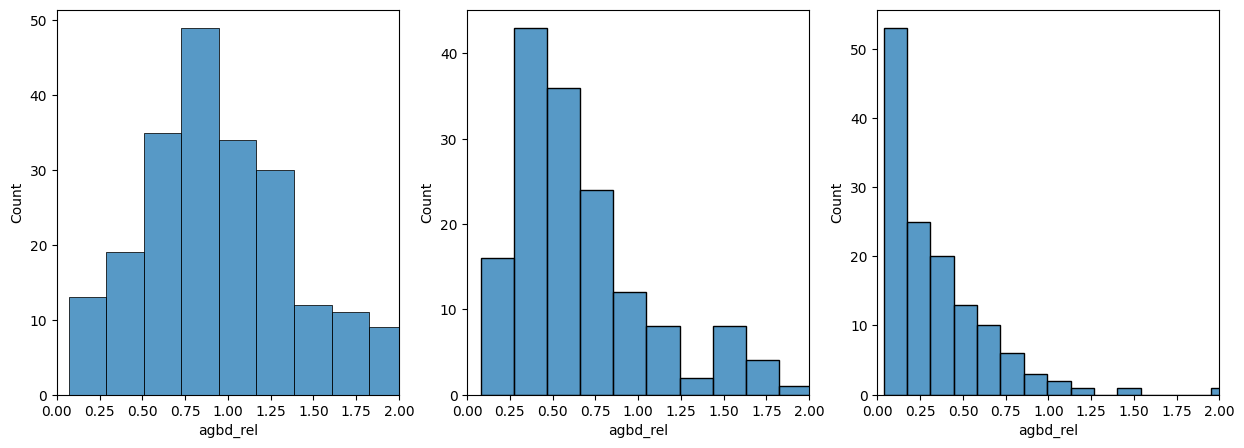

In [16]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000055  1971.653824 -3500.655278     inf      0.083987   
lognorm         0.000056  1997.165251 -3503.890628     inf      0.087530   
norm            0.000056  1983.900456 -3507.818414     inf      0.091064   
gamma           0.000062  2009.782361 -3477.256710     inf      0.113661   
burr            0.000622  1762.432522 -2940.715539     inf      0.697108   

             ks_pvalue  
beta      7.252761e-02  
lognorm   5.460774e-02  
norm      4.066833e-02  
gamma     4.687630e-03  
burr     7.329359e-113  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 31.68it/s]


{'norm': {'loc': 7.59809277687238, 'scale': 101.706437220158}}


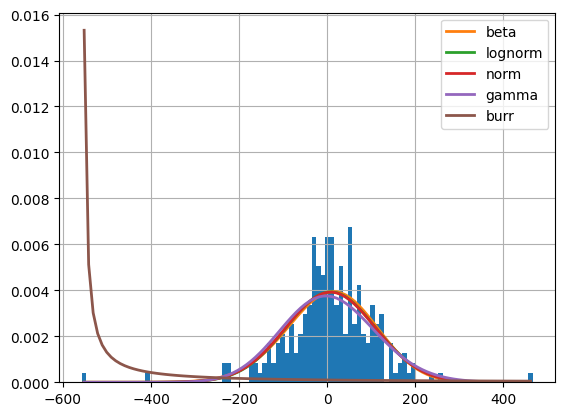

In [17]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  8.20it/s]


         sumsquare_error           aic          bic  kl_div  ks_statistic  \
norm            0.000042   2550.268724 -2448.449658     inf      0.102069   
beta            0.000042   2224.870281 -2436.197828     inf      0.100416   
burr            0.000117   2266.842154 -2270.038611     inf      0.269143   
gamma           0.000237  32537.670570 -2161.148106     inf      0.993827   
lognorm         0.000324   1876.078263 -2110.787744     inf      0.801437   

             ks_pvalue  
norm      6.368852e-02  
beta      7.108818e-02  
burr      7.453501e-11  
gamma     0.000000e+00  
lognorm  1.166523e-112  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s]


{'norm': {'loc': 69.50140915387942, 'scale': 129.48281673401937}}


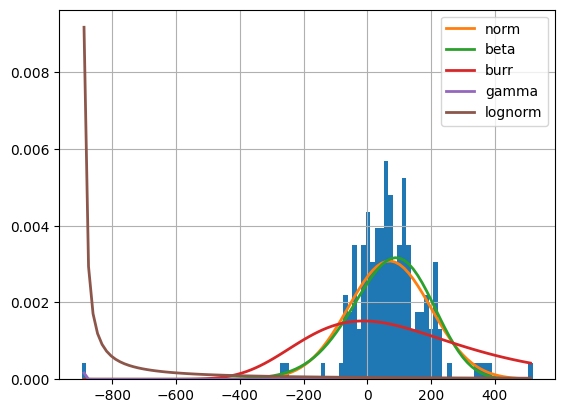

In [18]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000132  1489.551503 -1863.244376     inf      0.051166   
gamma           0.000132  1488.442552 -1868.145146     inf      0.051440   
lognorm         0.000132  1487.422738 -1867.932053     inf      0.056705   
burr            0.000133  1479.037125 -1862.488896     inf      0.061981   
norm            0.000141  1545.750371 -1864.547454     inf      0.074689   

         ks_pvalue  
beta      0.850436  
gamma     0.846012  
lognorm   0.752458  
burr      0.649836  
norm      0.413799  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s]


{'norm': {'loc': 195.07654218112722, 'scale': 147.53367791915954}}


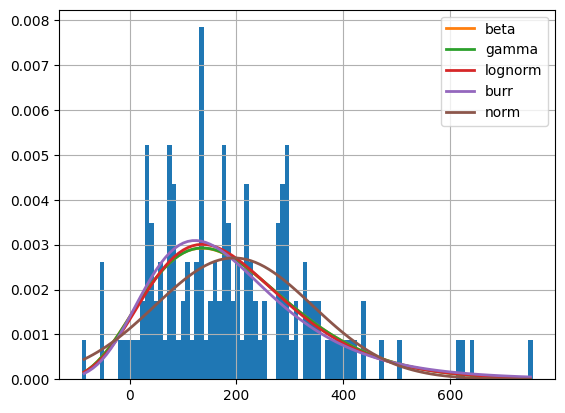

In [19]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [20]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9310585260391235, pvalue=6.233239258079948e-09)
Ttest results: TtestResult(statistic=1.132974327173694, pvalue=0.2584046965076397, df=230)
Wilcoxon test results: WilcoxonResult(statistic=11633.0, pvalue=0.08259201553979417)


In [21]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8171507120132446, pvalue=5.804347345643446e-13)
Ttest results: TtestResult(statistic=6.810741698885287, pvalue=1.8320891694472861e-10, df=161)
Wilcoxon test results: WilcoxonResult(statistic=1856.0, pvalue=2.0902290247683047e-15)


In [22]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.952465832233429, pvalue=0.00012190495908726007)
Ttest results: TtestResult(statistic=15.36316744270192, pvalue=1.972694734995806e-31, df=135)
Wilcoxon test results: WilcoxonResult(statistic=112.0, pvalue=5.359210452554276e-23)


In [25]:
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

<module 'src.data.pai_vertical' from '/home/jk871/fire-regen/src/data/pai_vertical.py'>

In [26]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(fire, gedi_burned_l2b)

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'fhd_normal', 'pai', 'pai_z', 'pavd_z', 'rh100', 'cover', 'cover_z',
       'beam_type', 'sensitivity', 'gridded_pft_class', 'geometry',
       'burn_severity_2x2', 'burn_severity_mean', 'burn_severity_std',
       'burn_severity_median', 'burn_year_2x2', 'burn_year_mean',
       'burn_year_std', 'burn_year_median', 'burn_counts_2x2',
       'burn_counts_mean', 'burn_counts_std', 'burn_counts_median',
       'land_cover_2x2', 'land_cover_mean', 'land_cover_std',
       'land_cover_median', 'gedi_year', 'gedi_month', 'time_since_burn',
       'index_right', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'FID', 'pai_z_np',
       'pai_z_padded', 'pai_z_delta_np'],
      dtype='object')
1
2
3


In [27]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]
close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 20])

In [28]:
def get_pai_z_df(df, severity):
    lala = get_severity(close_matches, severity).pai_z_delta_diff.to_numpy()
    new_lala = np.empty((lala.shape[0], lala[0].shape[0]))

    for i in range(lala.shape[0]):
        new_lala[i] = lala[i]

    return pd.melt(pd.DataFrame(new_lala))

(0.0, 13.0)

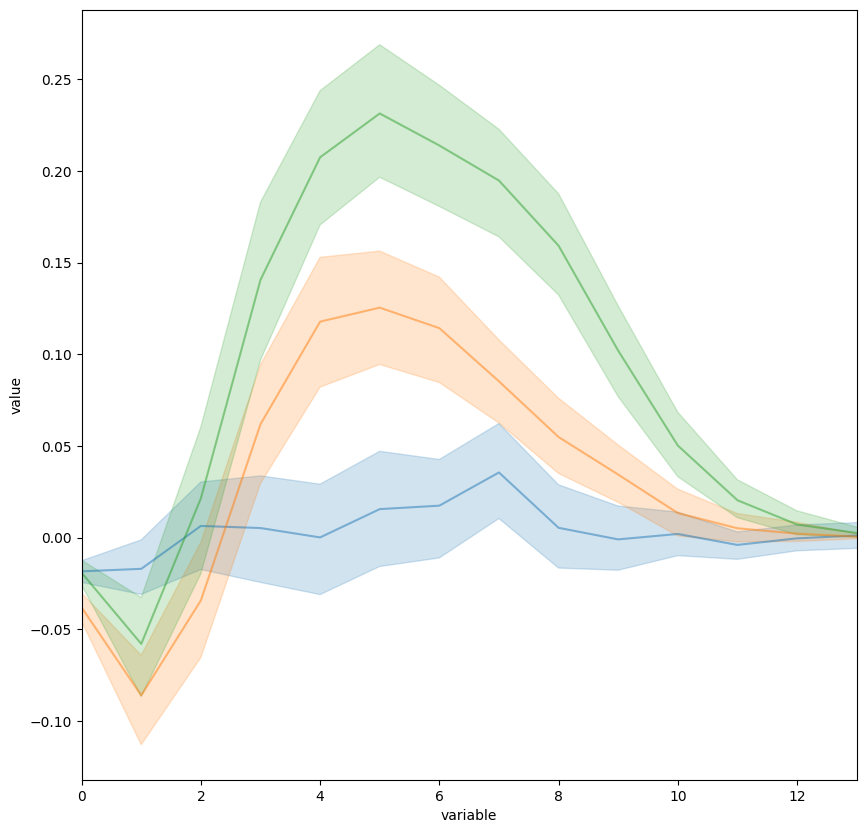

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(get_pai_z_df(close_matches, 2), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 3), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 4), x='variable', y='value', ax=ax, alpha=0.5)
ax.set_xlim((0, 13))